In [ ]:
## General Structure for all Notebooks 
## 1) Describe the problem being tackled, source of data, output 
## 2) Import libraries/set up wd; general working setup
## 3) Examine the quality of the data 
## 4) Build the right dataset 
## 5) Apply the structure

## Problem
### what are we solving for?

In [ ]:
#Build a model that predicts conversion rate and, based on the model, come up with ideas to improve it.

#We have data about all users who hit our site: whether they converted or not, some characteristics,
#whether they are repeat users and the number of pages visited during that session 
#(as a proxy for site activity/time spent on site).

In [39]:
import pandas as pd 
import numpy as np 
import os 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.linear_model import LogisticRegression



wd = os.getcwd()
print(wd)

## Github with answers: https://github.com/JifuZhao/DS-Take-Home/blob/master/01.%20Conversion%20Rate.ipynb 

/Users/annadudek/00_DataMasked


## Data Quality
### Are there any outliers, weird data anamolies ?

In [2]:

data_raw=pd.read_csv("https://drive.google.com/uc?export=download&id=1KvxyyF3QCtvIx0J7_8iWDEtFQpLgd0Yq")

print(data_raw.shape)
print('')
print(data_raw.dtypes)
print('')
print(data_raw.describe())
data_raw.head()


(316200, 6)

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
### Drop outliers or truncate in depending on dataset size 
def outlier_management (data, columns): 
    
    ## drop any columns which have fewer than 5 levels; assumption = they are categorical/boolean 
    for col in columns:
        if len(data[col].unique())<=5:
            columns.remove(col)
        else: 
            print(f"{[col]} is kept")
    print('')
    print(columns)
    print('')
    col_zscore_list = []
    
    ### calculates z-scores for all numeric columns
    for col in columns:
        col_zscore = col + '_zscore'
        col_zscore_list.append(col_zscore)
        data[col_zscore] = abs((data[col] - data[col].mean())/data[col].std(ddof=0))
    
    ### drops or truncates depending on size 
    df_length = len(data)

    if df_length>30000:
        for col in col_zscore_list:
#             df = data[(data[col] < 3).all(axis=1)]
            data = data[data[col] < 3]
    else:
        print('test')

    print(f" Before outlier management :{df_length}; After outlier management {len(data)}")  
    print('')
    print(f" % of dataset retained :{len(data)/df_length}")
    return data


def check_outlier_management(data, columns): 
    for col in columns: 
        print(f" {col} : {data[col].max()}")
        print('')



In [4]:
## deal with the outliers 
data = outlier_management(data=data_raw, columns=data_raw.select_dtypes('number').columns.tolist())

## check it was dealt with properly
check_outlier_management(data=data, columns=data.filter(like='zscore').columns.to_list())



['age'] is kept

['age', 'total_pages_visited']

 Before outlier management :316200; After outlier management 309384

 % of dataset retained :0.9784440227703984
 age_zscore : 2.9534291961136763

 total_pages_visited_zscore : 2.731746337954114



## Data Exploration 
### How do the different characteristics impact conversion? 

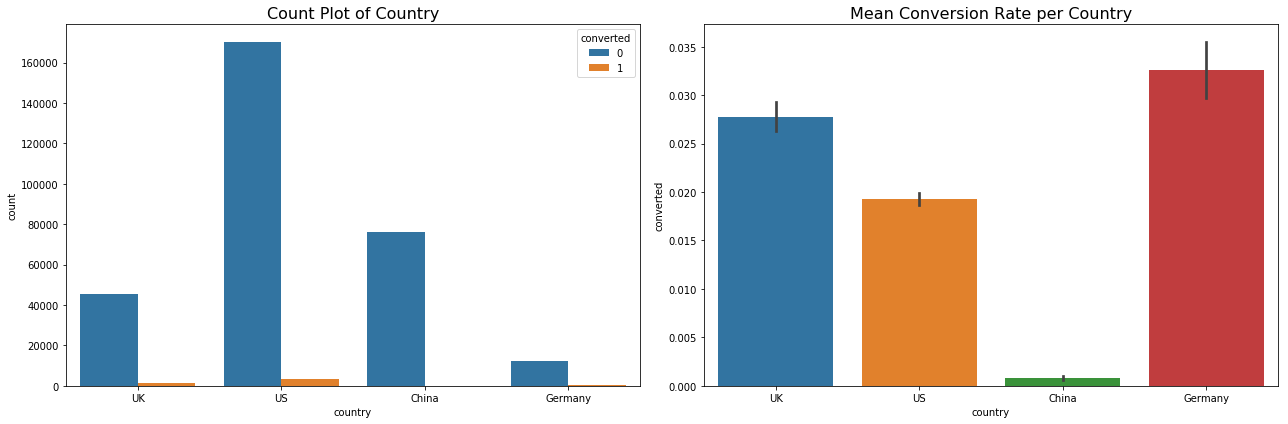

In [5]:
# Conversion by Country
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## plot 1
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
# ax[0].set_yscale('log')

## plot 2
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

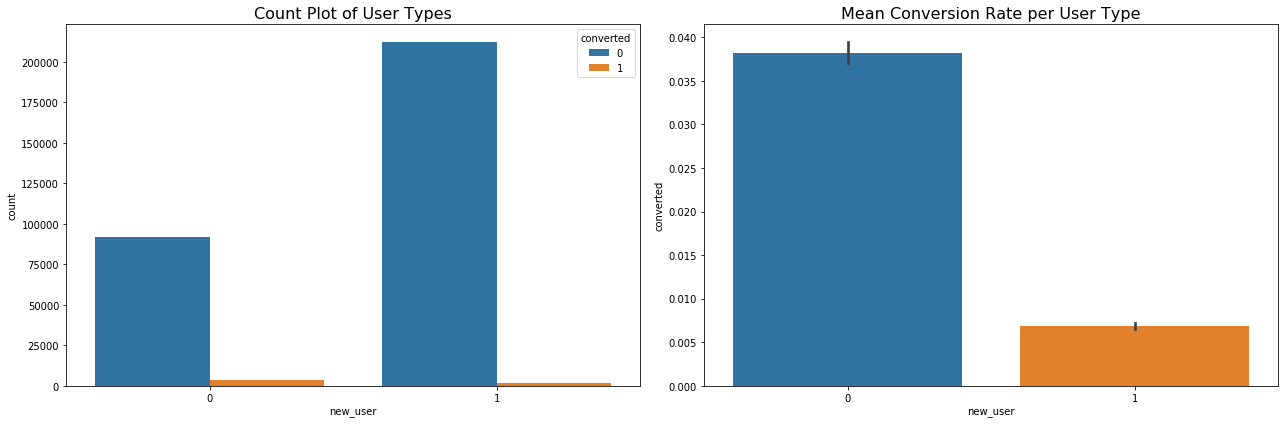

In [6]:
# Conversion by user type
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## plot 1
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
# ax[0].set_yscale('log')

## plot 2
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

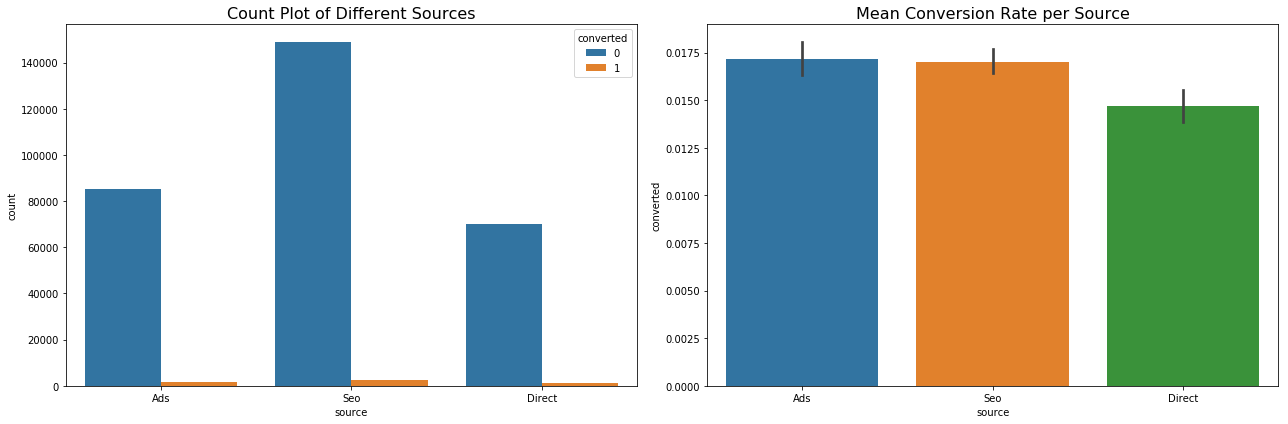

In [7]:
## Conversion by acquisition source
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## plot 1 
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
# ax[0].set_yscale('log')

## plot 2 
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

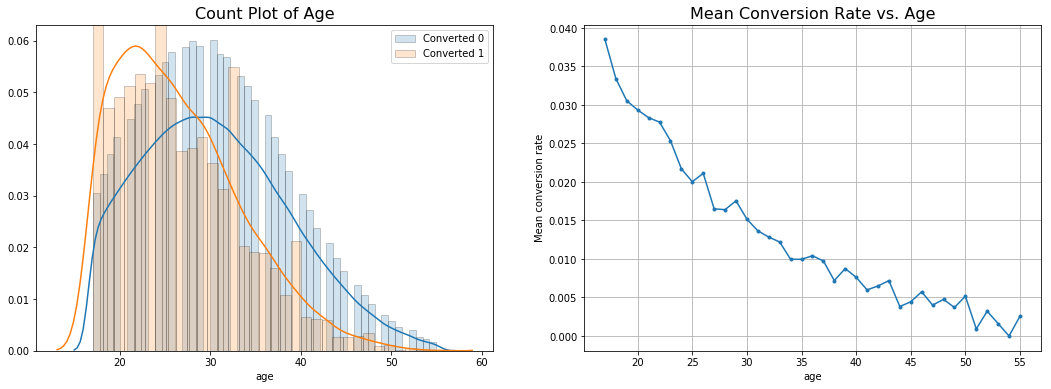

In [8]:
# Conversion by Age 
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## plot 1
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()


## plot 2 
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean conversion rate')
ax[1].grid(True)
plt.show()

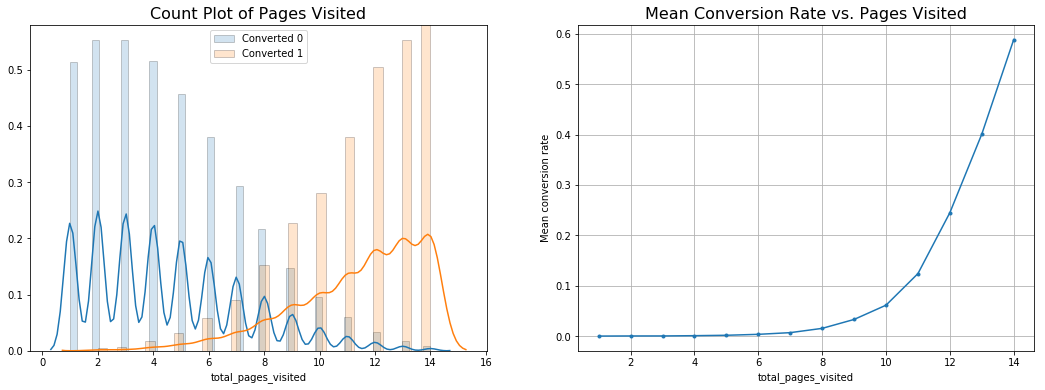

In [9]:
# Conversion by total pages View 
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## plot 1
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Pages Visited', fontsize=16)
ax[0].legend()


## plot 2 
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Pages Visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean conversion rate')
ax[1].grid(True)
plt.show()

# Create Features & Dataset

In [10]:
## Create Dummy Variables for source & country

dummies_country = pd.get_dummies(data['country']).rename(columns=lambda x: 'Acq_Country_' + str(x))
data = data.join(dummies_country)

dummies_source = pd.get_dummies(data['source']).rename(columns=lambda x: 'Acq_Source_' + str(x))
data = data.join(dummies_source)



## Bin Age 
bins = [20, 30, 40, 50, 60, 70, 80, 1000]
labels = ['0-20','20-30','30-40','40-50', '50-60', '60-70', '70-80']
data['age_bin']=pd.cut(data['age'], bins=bins, labels=labels)

dummies_age = pd.get_dummies(data['age_bin']).rename(columns=lambda x:'agegroup' + str(x))  
data = data.join(dummies_age)


## Reorganize dataframe to only what's needed
print(data.columns)
data=data[['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted', 'Acq_Country_China', 'Acq_Country_Germany',
       'Acq_Country_UK', 'Acq_Country_US', 'Acq_Source_Ads', 'Acq_Source_Direct',
       'Acq_Source_Seo', 'age_bin','agegroup0-20', 'agegroup20-30', 
       'agegroup30-40', 'agegroup40-50',
       'agegroup50-60', 'agegroup60-70', 'agegroup70-80']]

data.head()

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted', 'age_zscore', 'total_pages_visited_zscore',
       'Acq_Country_China', 'Acq_Country_Germany', 'Acq_Country_UK',
       'Acq_Country_US', 'Acq_Source_Ads', 'Acq_Source_Direct',
       'Acq_Source_Seo', 'age_bin', 'agegroup0-20', 'agegroup20-30',
       'agegroup30-40', 'agegroup40-50', 'agegroup50-60', 'agegroup60-70',
       'agegroup70-80'],
      dtype='object')


,country,age,new_user,source,total_pages_visited,converted,Acq_Country_China,Acq_Country_Germany,Acq_Country_UK,Acq_Country_US,...,Acq_Source_Direct,Acq_Source_Seo,age_bin,agegroup0-20,agegroup20-30,agegroup30-40,agegroup40-50,agegroup50-60,agegroup60-70,agegroup70-80
0,UK,25,1,Ads,1,0,0,0,1,0,...,0,0,0-20,1,0,0,0,0,0,0
1,US,23,1,Seo,5,0,0,0,0,1,...,0,1,0-20,1,0,0,0,0,0,0
2,US,28,1,Seo,4,0,0,0,0,1,...,0,1,0-20,1,0,0,0,0,0,0
3,China,39,1,Seo,5,0,1,0,0,0,...,0,1,20-30,0,1,0,0,0,0,0
4,US,30,1,Seo,6,0,0,0,0,1,...,0,1,0-20,1,0,0,0,0,0,0


## Random Forest 

In [21]:
## split into train and test sets 
train, test = train_test_split(data, test_size=0.3, random_state=42)
print(train.shape)
print(test.shape)


variables_to_use = ['age', 'new_user', 'total_pages_visited',
       'Acq_Country_China', 'Acq_Country_Germany',
       'Acq_Country_UK', 'Acq_Country_US', 'Acq_Source_Ads', 'Acq_Source_Direct',
       'Acq_Source_Seo', 'agegroup0-20', 'agegroup20-30', 'agegroup30-40',
       'agegroup40-50','agegroup50-60', 'agegroup60-70', 'agegroup70-80']

X_train = train[variables_to_use]
y_train = train['converted']

X_test = test[variables_to_use]
y_test = test['converted']


clf=RandomForestClassifier(n_estimators=100, max_features = 5, oob_score=True)

## Train the model 
clf.fit(X_train,y_train)


## Predictions 
y_pred = clf.predict(X_test)
test['y_hat']= clf.predict(X_test)


(216568, 21)
(92816, 21)


## Reviewing Accuracy, F-Score (Precision v Recall), Confusion Matrix

In [22]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("Out of Bag Score:", clf.oob_score_)
## which features are important 
feature_imp = pd.Series(clf.feature_importances_,
                        index=variables_to_use).sort_values(ascending=False)
print('')
print('Feature Importance sorted: ')
print(feature_imp)


## confusion matrix 
confusion_matrix(test['converted'], test['y_hat']) 

df_confusion = pd.crosstab(test['converted'], test['y_hat'],
                           rownames=['Actual'], colnames=['Predicted'], margins=True)
print('')
print('confusion matrix - absolute values')
print(df_confusion)

print('')
print('confusion matrix - % values')
print(df_confusion / df_confusion.sum(axis=1))       ### represented as a percentage 


## Prediction v Recall 
precision, recall, fscore, support = score(test['converted'], test['y_hat'],labels=[0,1])


## Precision: % of results that are TP of all the records identified positively. TP/(TP + FP) 
## Recall: % of results that are TP from all records that are TP and which were missed as TP (FN). TP/(TP + FN)
## Accuracy: % of all positives and negatives identified correctly (TP + TN)/total records
## F1-Score: 
## Support: 


classification_report= pd.DataFrame(columns = ('metric', 'not_converted', 'converted'))

classification_report.loc[0] = ['precision', precision[0], precision[1]]
classification_report.loc[1] = ['recall', recall[0], recall[1]]
classification_report.loc[2] = ['fscore', fscore[0], fscore[1]]
classification_report.loc[3] = ['support', support[0], support[1]]

classification_report


Accuracy: 0.9860476641958283
Out of Bag Score: 0.9856765542462413

Feature Importance sorted: 
total_pages_visited    0.678840
age                    0.166925
new_user               0.082335
Acq_Country_China      0.022906
Acq_Country_UK         0.008929
Acq_Country_US         0.006691
agegroup20-30          0.006222
Acq_Country_Germany    0.004941
agegroup30-40          0.004863
agegroup0-20           0.004483
Acq_Source_Seo         0.004000
Acq_Source_Direct      0.003858
Acq_Source_Ads         0.003806
agegroup40-50          0.001201
agegroup60-70          0.000000
agegroup50-60          0.000000
agegroup70-80          0.000000
dtype: float64

confusion matrix - absolute values
Predicted      0    1    All
Actual                      
0          90962  336  91298
1            959  559   1518
All        91921  895  92816

confusion matrix - % values
Predicted         0         1       All
Actual                                 
0          0.498160  0.110672  0.491823
1          0.005

,metric,not_converted,converted
0,precision,0.989567,0.624581
1,recall,0.996320,0.368248
2,fscore,0.992932,0.463324
3,support,91298.000000,1518.000000


## Logistic Regression for Comparison 

In [34]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train,y_train)

## Predict for test set 
predictions = logisticRegr.predict(X_test)
test['y_hat_lr']= clf.predict(X_test)

lr_score = logisticRegr.score(X_test, y_test)
print(lr_score)

confusion_matrix_lr = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix_lr)

0.9871789346664368
[[91070   228]
 [  962   556]]


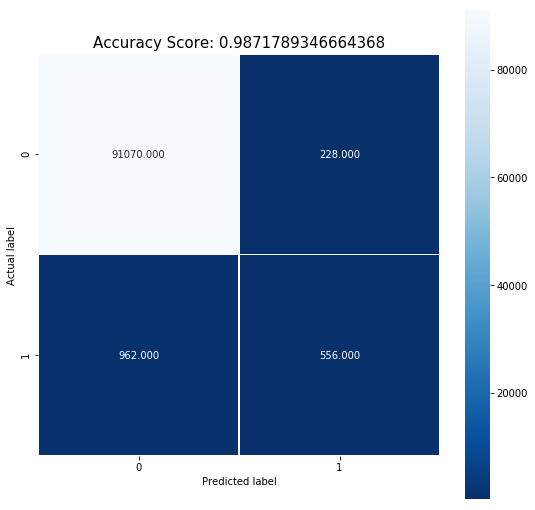

In [32]:
## Confusion Matrix

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix_lr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [42]:
## Prediction v Recall 
del precision, recall, fscore, support
precision, recall, fscore, support = score(test['converted'], test['y_hat_lr'],labels=[0,1])


## Precision: % of results that are TP of all the records identified positively. TP/(TP + FP) 
## Recall: % of results that are TP from all records that are TP and which were missed as TP (FN). TP/(TP + FN)
## Accuracy: % of all positives and negatives identified correctly (TP + TN)/total records
## F1-Score: 
## Support: 


classification_report_lr= pd.DataFrame(columns = ('metric', 'not_converted', 'converted'))

classification_report_lr.loc[0] = ['precision', precision[0], precision[1]]
classification_report_lr.loc[1] = ['recall', recall[0], recall[1]]
classification_report_lr.loc[2] = ['fscore', fscore[0], fscore[1]]
classification_report_lr.loc[3] = ['support', support[0], support[1]]

classification_report_lr


,metric,not_converted,converted
0,precision,0.989567,0.624581
1,recall,0.996320,0.368248
2,fscore,0.992932,0.463324
3,support,91298.000000,1518.000000
